In [1]:
import sqlite3

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

to preface, the data given currently has the 500 cities data "df500" (health information for each tract and fips id),
the access data from the food atlas "food_atlas" (access variable measures for each county), variable list "var_list"(information about the variables and how they are measured like count vs percentage), and I will also add the 500 cities tract shape files for graphing in maps as a gpd file "tracts"


**We will start with loading the data, understanding the datasets, and cleaning/merging as needed**

In [3]:
conn = sqlite3.connect("challenge.db")


In [4]:
schema = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
schema

,name
0,five_hundred_cities
1,access
2,variable_list


In [5]:
df500 = pd.read_sql("SELECT * FROM five_hundred_cities;", conn)

In [6]:
df500.head()

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,...,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)"
1,1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,...,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)"
2,2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,...,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)"
3,3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,...,"(82.1, 86.5)",21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)"
4,4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,...,"(82.2, 87.1)",25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)"


The place fips has normally 7 digits, here it has 6 due to a missing leading 0. Add leading 0, then cut it to 5 digits

In [7]:
df500["TractFIPS"] = (
    df500["TractFIPS"]
    .astype(str)
    .str.zfill(11)
)

In [8]:
df500["PlaceFIPS"] = (
    df500["PlaceFIPS"]
    .astype(str)
    .str.zfill(7)
)

In [9]:
df500["TractFIPS"].str.len().value_counts()


TractFIPS
11    27210
Name: count, dtype: int64

In [10]:
df500["county_fips"] = df500["TractFIPS"].str[:5]

In [11]:
df500["PlaceFIPS"].str.len().value_counts()

PlaceFIPS
7    27210
Name: count, dtype: int64

In [12]:
df500

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,county_fips
0,0,AL,Birmingham,0107000,01073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,...,20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",01073
1,1,AL,Birmingham,0107000,01073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,...,22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",01073
2,2,AL,Birmingham,0107000,01073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,...,19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",01073
3,3,AL,Birmingham,0107000,01073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,...,21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",01073
4,4,AL,Birmingham,0107000,01073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,...,25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)",01073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27205,27205,WY,Cheyenne,5613900,56021001000,5613900-56021001000,3026,17.2,"(14.9, 19.9)",24.2,...,12.2,"(11.1, 13.4)",34.5,"(33.0, 35.8)",3.0,"( 2.8, 3.3)",16.2,"(11.4, 21.5)","(41.14141598330, -104.829095061)",56021
27206,27206,WY,Cheyenne,5613900,56021001200,5613900-56021001200,4638,9.8,"( 7.8, 12.0)",25.2,...,8.8,"( 7.6, 10.1)",29.0,"(27.5, 30.7)",2.5,"( 2.2, 2.8)",8.1,"( 4.7, 12.2)","(41.17926735060, -104.838572685)",56021
27207,27207,WY,Cheyenne,5613900,56021001501,5613900-56021001501,3312,14.5,"(12.9, 16.1)",22.0,...,9.6,"( 8.9, 10.4)",32.9,"(31.9, 33.9)",2.3,"( 2.2, 2.5)",11.9,"( 8.5, 15.9)","(41.16037417080, -104.756560525)",56021
27208,27208,WY,Cheyenne,5613900,56021001502,5613900-56021001502,4518,16.6,"(14.3, 18.9)",25.2,...,12.0,"(10.8, 13.3)",34.8,"(33.3, 36.1)",3.2,"( 2.8, 3.6)",19.7,"(13.1, 27.1)","(41.15063392830, -104.755675636)",56021


In [19]:
df500.describe()

,index,Population2010,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,...,KIDNEY_CrudePrev,LPA_CrudePrev,MAMMOUSE_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PAPTEST_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev
count,27210.000000,27210.000000,27209.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,...,27210.000000,27210.000000,27173.000000,27210.000000,27210.000000,25008.000000,27210.000000,27210.000000,27210.000000,27150.000000
mean,13604.500000,3785.703087,16.990915,21.430129,18.066953,30.653208,70.744274,5.648912,9.741352,5.602977,...,3.099666,27.593671,79.190976,13.921040,30.472922,83.085749,12.882962,36.716836,3.211466,16.108107
std,7854.994749,1944.825182,8.869361,5.995361,4.032559,8.260472,7.927116,1.803257,1.710538,2.118858,...,0.960904,8.830258,3.266690,3.617324,8.180685,3.122528,4.011045,5.956493,1.449541,8.780165
min,0.000000,50.000000,2.400000,2.400000,2.800000,5.300000,9.600000,0.700000,5.600000,0.300000,...,0.700000,8.400000,59.200000,4.200000,9.600000,63.400000,3.400000,16.100000,0.300000,2.800000
25%,6802.250000,2457.250000,10.300000,17.300000,15.500000,25.300000,66.700000,4.500000,8.500000,4.200000,...,2.500000,20.700000,77.200000,11.200000,24.500000,81.300000,9.900000,32.400000,2.300000,9.200000
50%,13604.500000,3611.000000,15.000000,21.000000,17.800000,29.500000,71.700000,5.500000,9.400000,5.300000,...,2.900000,26.500000,79.400000,13.500000,29.500000,83.400000,12.300000,36.100000,2.900000,14.100000
75%,20406.750000,4900.000000,21.600000,25.100000,20.300000,34.900000,75.900000,6.600000,10.700000,6.700000,...,3.600000,33.800000,81.500000,16.400000,35.600000,85.300000,15.400000,40.600000,3.800000,21.300000
max,27209.000000,28960.000000,57.800000,58.400000,44.100000,70.300000,92.800000,22.900000,17.800000,35.800000,...,12.300000,61.600000,88.200000,32.600000,58.600000,90.300000,33.600000,58.700000,19.500000,57.000000


In [13]:
food_atlas = pd.read_sql("SELECT * FROM access;", conn)

In [14]:
food_atlas

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
0,0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,...,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,...,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,...,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025
3,3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,...,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951
4,4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,...,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,3138,56037,WY,Sweetwater,13391.715505,18934.737809,41.391428,30.570505,43.224074,2414.618816,...,2661.350520,6.075311,114.722086,0.261887,189.621441,0.432866,27.720443,0.063280,1605.391465,3.664775
3139,3139,56039,WY,Teton,6212.423697,6212.390430,-0.000535,29.174527,29.174370,1059.463554,...,736.174507,3.457192,53.489780,0.251196,32.482255,0.152542,8.468847,0.039771,460.434464,2.162273
3140,3140,56041,WY,Uinta,4270.147119,4686.017653,9.739021,20.220414,22.189685,1518.415783,...,535.616715,2.536304,13.831709,0.065497,40.339658,0.191020,6.586104,0.031187,350.320469,1.658871
3141,3141,56043,WY,Washakie,931.411647,931.411647,0.000000,10.915407,10.915407,233.628356,...,35.474502,0.415733,6.366775,0.074614,5.006976,0.058678,0.000000,0.000000,34.160542,0.400334


notice here that the fips codes are 4 digits, not the nromal 5 for county fips. This is due to a missing leading 0 which we can add in when combining the datasets

In [16]:
food_atlas["county_fips"] = (food_atlas["FIPS"].astype(str).str.zfill(5))

In [15]:
var_list = pd.read_sql("SELECT * FROM variable_list;", conn)

In [35]:
print(df500.shape)
print(food_atlas.shape)
print(var_list.shape)

(27210, 64)
(3143, 45)
(281, 8)


In [33]:
#df500.info()

In [32]:
#food_atlas.info()

In [198]:
var_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             281 non-null    int64 
 1   Category Name     281 non-null    object
 2   Category Code     281 non-null    object
 3   Subcategory Name  281 non-null    object
 4   Variable Name     281 non-null    object
 5   Variable Code     281 non-null    object
 6   Geography         281 non-null    object
 7   Units             281 non-null    object
dtypes: int64(1), object(7)
memory usage: 17.7+ KB


In [53]:
food_atlas.head()

,index,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,...,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15,county_fips
0,0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,...,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808,01001
1,1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,...,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712,01003
2,2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,...,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025,01005
3,3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,...,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951,01007
4,4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,...,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990,01009


In [22]:
access_cols = [
    'county_fips', 'index', 'FIPS', 'State', 'County',

    
    'LACCESS_POP15', 'LACCESS_CHILD15', 'LACCESS_SENIORS15',
    'LACCESS_LOWI15', 'LACCESS_HHNV15', 'LACCESS_SNAP15',
    'LACCESS_BLACK15', 'LACCESS_WHITE15', 'LACCESS_HISP15',
    'LACCESS_NHASIAN15', 'LACCESS_NHNA15', 'LACCESS_NHPI15',
    'LACCESS_MULTIR15',


    'PCT_LACCESS_POP15', 'PCT_LACCESS_CHILD15', 'PCT_LACCESS_SENIORS15',
    'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15',
    'PCT_LACCESS_BLACK15', 'PCT_LACCESS_WHITE15', 'PCT_LACCESS_HISP15',
    'PCT_LACCESS_NHASIAN15', 'PCT_LACCESS_NHNA15',
    'PCT_LACCESS_NHPI15', 'PCT_LACCESS_MULTIR15'
]

food = food_atlas[access_cols].copy()

In [23]:
county_shp = gpd.read_file("tl_2010_us_county10/tl_2010_us_county10.shp")
county_shp.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,02,013,01419964,02013,Aleutians East,Aleutians East Borough,04,H1,G4020,None,None,None,A,18083148800,20792209033,+55.2437223,-161.9507485,"MULTIPOLYGON (((-162.63769 54.80112, -162.6411..."
1,02,016,01419965,02016,Aleutians West,Aleutians West Census Area,05,H5,G4020,None,None,None,S,11370762625,25190643524,+51.9594469,+178.3388130,"MULTIPOLYGON (((177.44593 52.11133, 177.44302 ..."
2,28,107,00695776,28107,Panola,Panola County,06,H1,G4020,None,None,None,A,1774515519,51767046,+34.3652052,-089.9630654,"POLYGON ((-90.13476 34.22603, -90.13476 34.226..."
3,28,101,00695773,28101,Newton,Newton County,06,H1,G4020,None,None,None,A,1497282694,3879399,+32.4019702,-089.1184115,"POLYGON ((-89.13497 32.57697, -89.13466 32.576..."
4,28,027,00695738,28027,Coahoma,Coahoma County,06,H1,G4020,None,17260,None,A,1430818231,79539470,+34.2286699,-090.6031650,"POLYGON ((-90.59062 33.9869, -90.59473 33.9869..."


In [25]:
county_shp = county_shp.rename(columns={'GEOID10': 'county_fips'})
county_shp['county_fips'] = county_shp['county_fips'].astype(str)

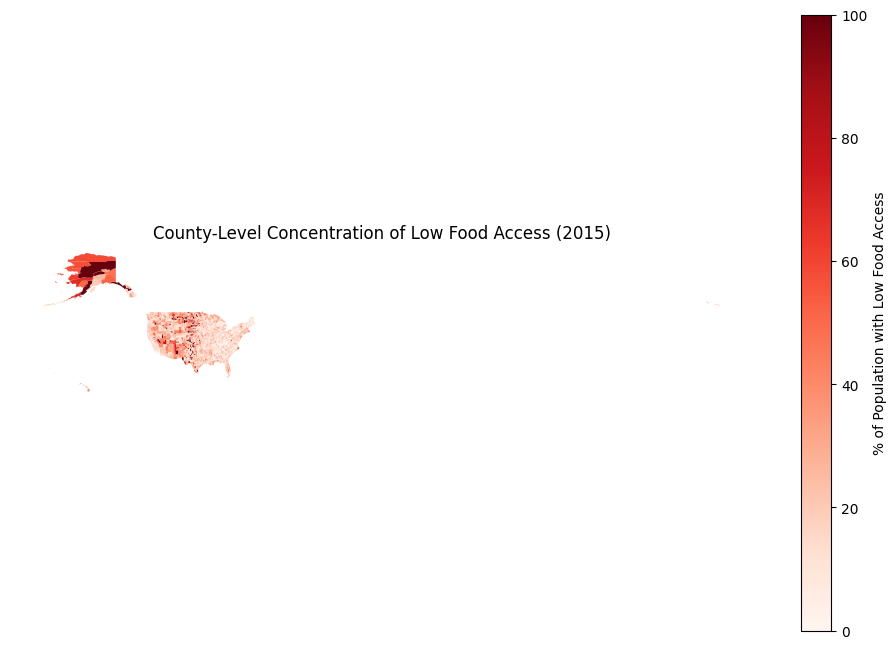

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt


gdf_county = county_shp.merge(
    food,
    on = "county_fips",
    how='left'
)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_county.plot(
    column='PCT_LACCESS_POP15',
    cmap='Reds',
    linewidth=0.1,
    ax=ax,
    legend=True,
    legend_kwds={'label': '% of Population with Low Food Access'}
)

ax.set_title('County-Level Concentration of Low Food Access (2015)')
ax.axis('off')
plt.show()


In [28]:
threshold = food['PCT_LACCESS_POP15'].quantile(0.90)

food['high_access_need'] = food['PCT_LACCESS_POP15'] >= threshold


In [208]:
food.describe()

,index,FIPS,LACCESS_POP15,LACCESS_CHILD15,LACCESS_SENIORS15,LACCESS_LOWI15,LACCESS_HHNV15,LACCESS_SNAP15,LACCESS_BLACK15,LACCESS_WHITE15,...,PCT_LACCESS_LOWI15,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_BLACK15,PCT_LACCESS_WHITE15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15
count,3143.000000,3143.000000,3124.000000,3124.000000,3124.000000,3123.000000,3140.000000,3123.000000,3124.000000,3124.000000,...,3123.000000,3140.000000,3123.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000,3124.000000
mean,1571.000000,30390.411709,19287.747386,4742.980901,2570.415541,5833.959524,673.746375,804.471927,2269.428677,14769.991630,...,8.651256,3.289225,2.917896,1.879652,18.976973,2.021269,0.249350,0.804746,0.019207,1.154542
std,907.450274,15164.717720,47803.525596,12216.611681,6184.202345,13989.348252,1100.580817,1870.844498,8793.761183,35114.751058,...,8.368703,3.213497,3.160642,4.139239,17.529867,5.030497,0.693856,4.835109,0.134887,1.864479
min,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,785.500000,18178.000000,1631.358726,354.654348,273.978490,608.235919,126.004765,68.476725,7.000000,1317.210782,...,3.625438,1.683158,1.132022,0.056762,8.518008,0.197446,0.027088,0.026997,0.000000,0.221558
50%,1571.000000,29177.000000,4131.174278,956.123349,662.445677,1636.858816,340.348323,218.176102,86.612488,3350.954204,...,6.508531,2.672985,2.128783,0.257221,15.185443,0.579669,0.085588,0.072033,0.003242,0.572597
75%,2356.500000,45082.000000,13119.029389,3020.174780,1846.511461,4859.016156,755.806483,687.003195,1007.743296,10672.119575,...,10.679796,4.036167,3.668171,1.682592,23.658599,1.673132,0.249311,0.186646,0.013054,1.318699
max,3142.000000,56045.000000,740267.412661,219002.492912,86014.561483,259479.516033,13845.220204,29461.297953,167913.190404,413148.285289,...,71.844209,60.602394,37.254488,50.136324,99.163179,79.323968,25.087551,83.844210,4.469546,27.120652


In [214]:
total_low_access_people_over_50 = food.loc[
    food["PCT_LACCESS_POP15"] > 33,
    "LACCESS_POP15"
].sum()

print(total_low_access_people_over_50)


11185936.243167844


In [215]:
total_population = food["LACCESS_POP15"].sum()
print(total_population)


60254922.83399637


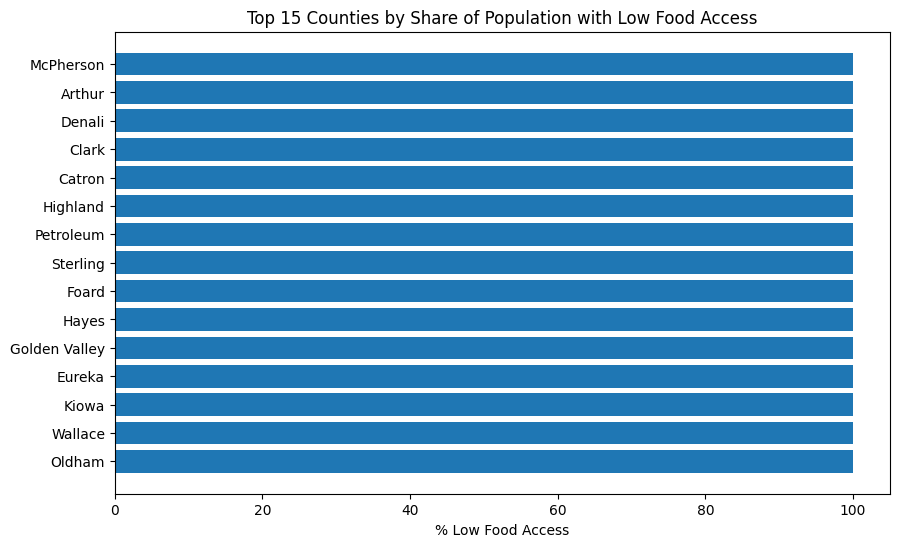

In [32]:
top_pct = (
    food.sort_values('PCT_LACCESS_POP15', ascending=False).head(15)
      
)

plt.figure(figsize=(10, 6))
plt.barh(
    top_pct['County'],
    top_pct['PCT_LACCESS_POP15']
)
plt.gca().invert_yaxis()
plt.xlabel('% Low Food Access')
plt.title('Top 15 Counties by Share of Population with Low Food Access')
plt.show()
#TODO:something with the percentiles for this and the bar graph. Also put counts for the percentile as well to show total target number vs percentile #

In [33]:
total_low_access = food['LACCESS_POP15'].sum()
total_low_access


60254922.83399637

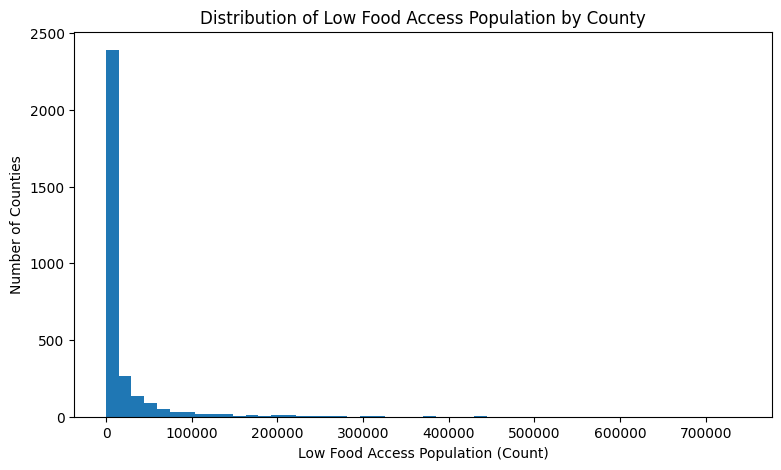

In [202]:
plt.figure(figsize=(9, 5))
plt.hist(food['LACCESS_POP15'], bins=50)
plt.xlabel('Low Food Access Population (Count)')
plt.ylabel('Number of Counties')
plt.title('Distribution of Low Food Access Population by County')
plt.show()


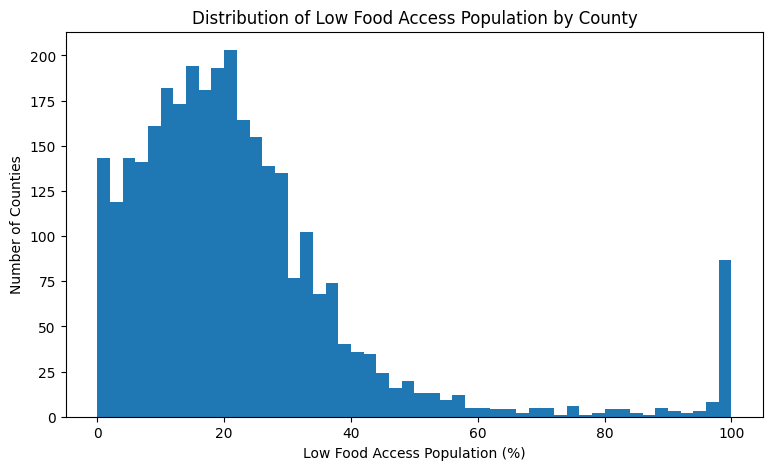

In [59]:
plt.figure(figsize=(9, 5))
plt.hist(food['PCT_LACCESS_POP15'], bins=50)
plt.xlabel('Low Food Access Population (%)')
plt.ylabel('Number of Counties')
plt.title('Distribution of Low Food Access Population by County')
plt.show()

In [35]:
subgroups = [
    'POP', 'CHILD', 'SENIORS', 'LOWI', 'HHNV', 'SNAP',
    'WHITE', 'BLACK', 'HISP', 'NHASIAN', 'NHNA', 'NHPI', 'MULTIR'
]

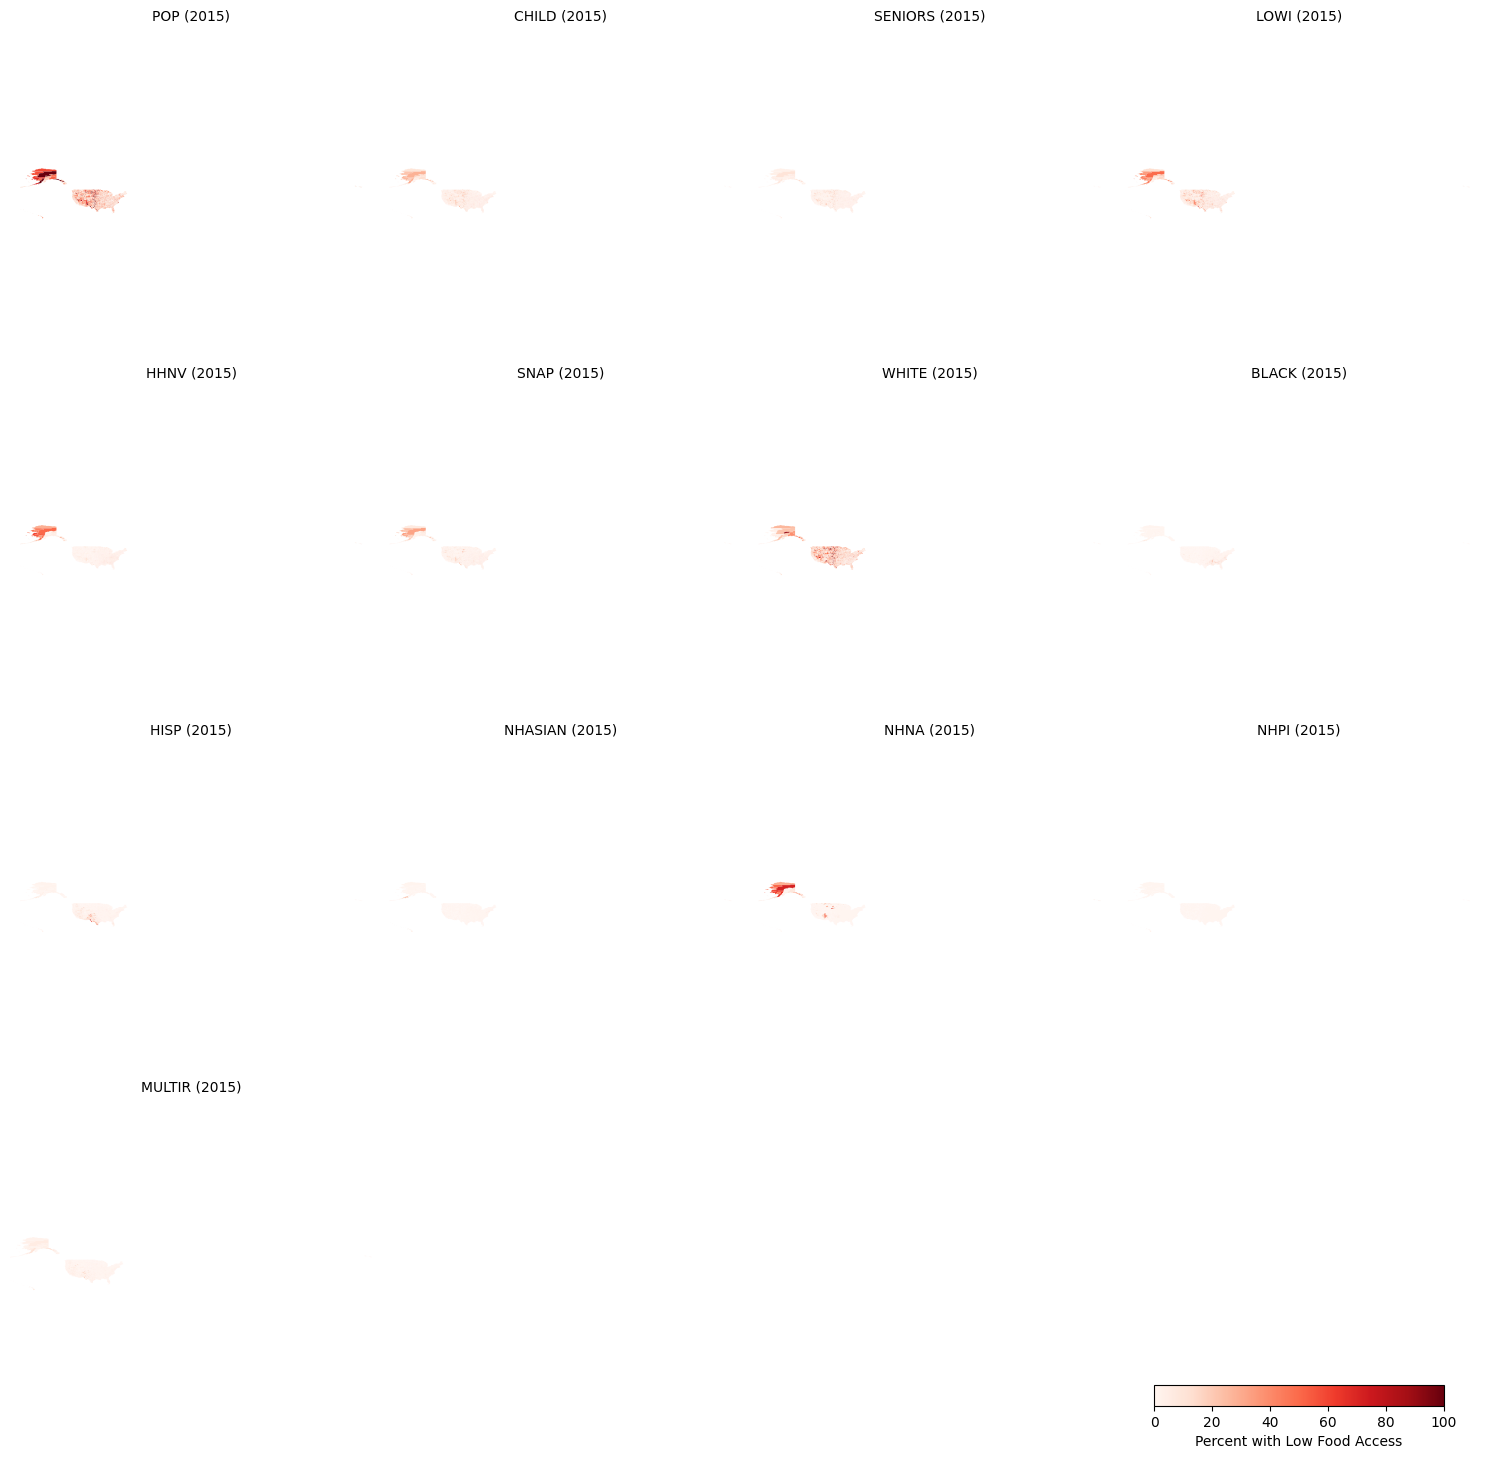

In [188]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()

vmin = 0
vmax = 100
cmap = 'Reds'

for ax, g in zip(axes, subgroups):

    gdf_county.plot(
        column=f'PCT_LACCESS_{g}15',
        ax=ax,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=False
    )

    ax.set_title(f'{g} (2015)', fontsize=10, pad=2)
    ax.set_axis_off()

    
    ax.set_aspect('equal', adjustable='datalim')
    ax.margins(0, 0)
    ax.set_anchor('C')

for ax in axes[len(subgroups):]:
    ax.set_visible(False)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cax = inset_axes(axes[-1], width="80%", height="6%", loc='lower center',
                 borderpad=2)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label('Percent with Low Food Access')

plt.subplots_adjust(
    left=0.01, right=0.99,
    top=0.97, bottom=0.03,
    wspace=0.02, hspace=0.05
)

plt.show()


In [196]:
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

vmin = 0
vmax = 100
cmap = 'Reds'

def plot_subgroup(g):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    gdf_county.plot(
        column=f'PCT_LACCESS_{g}15',
        ax=ax,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        legend=True
    )

    ax.set_title(f'Low Food Access Concentration for Subgroup: {g} (2015)')
    ax.axis('off')
    ax.set_aspect('equal')

    plt.show()

interact(
    plot_subgroup,
    g=Dropdown(options=subgroups, description="Subgroup:")
)


interactive(children=(Dropdown(description='Subgroup:', options=('POP', 'CHILD', 'SENIORS', 'LOWI', 'HHNV', 'S…

<function __main__.plot_subgroup(g)>

In [41]:
count_cols = [f'LACCESS_{g}15' for g in subgroups]
pct_cols = [f'PCT_LACCESS_{g}15' for g in subgroups]

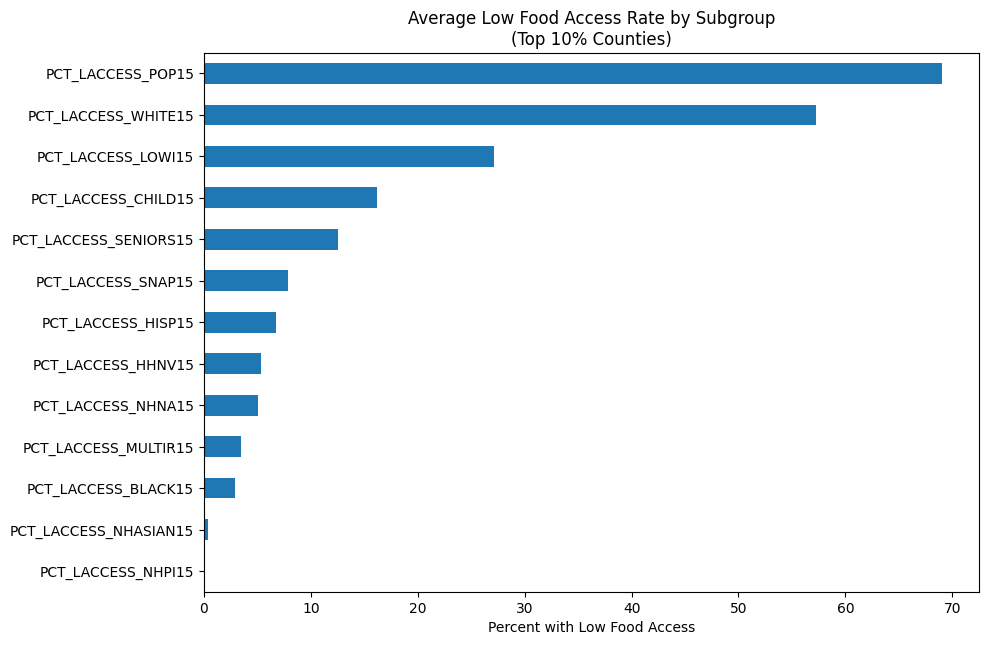

In [42]:
subgroup_pct_target = (
    food.loc[food['high_access_need'], pct_cols]
    .mean()
    .sort_values()
)

subgroup_pct_target.plot(
    kind='barh',
    figsize=(10, 7),
    title='Average Low Food Access Rate by Subgroup\n(Top 10% Counties)'
)
plt.xlabel('Percent with Low Food Access')
plt.show()


LACCESS_POP15        6.025492e+07
LACCESS_WHITE15      4.614145e+07
LACCESS_LOWI15       1.821946e+07
LACCESS_CHILD15      1.481707e+07
LACCESS_SENIORS15    8.029978e+06
LACCESS_HISP15       7.266679e+06
LACCESS_BLACK15      7.089695e+06
LACCESS_MULTIR15     4.032457e+06
LACCESS_SNAP15       2.512366e+06
LACCESS_NHASIAN15    2.171380e+06
LACCESS_HHNV15       2.115564e+06
LACCESS_NHNA15       7.193307e+05
LACCESS_NHPI15       1.006061e+05
dtype: float64


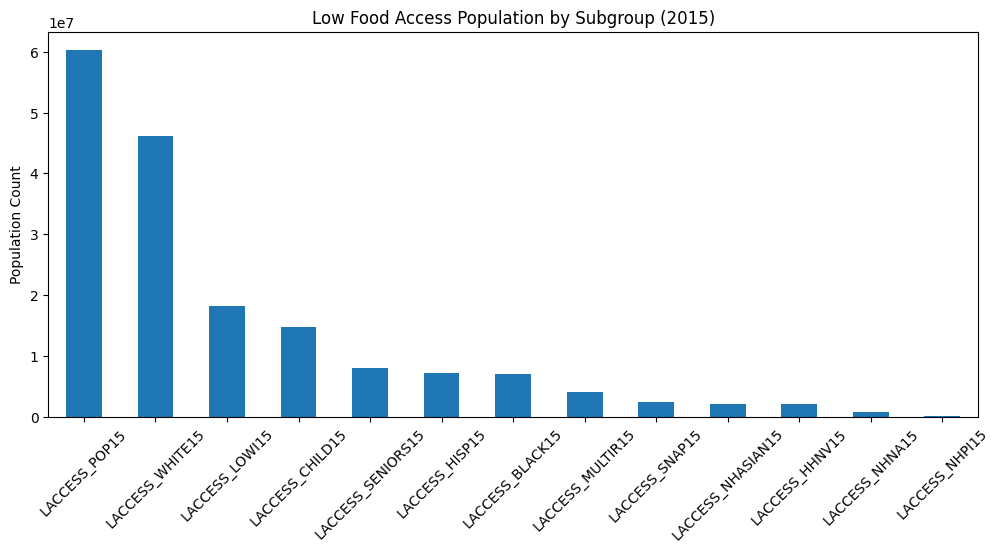

In [44]:
subgroup_counts = food[count_cols].sum().sort_values(ascending=False)
print(subgroup_counts)
subgroup_counts.plot(
    kind='bar',
    figsize=(12, 5),
    title='Low Food Access Population by Subgroup (2015)'
)
plt.ylabel('Population Count')
plt.xticks(rotation=45)
plt.show()


going to do a left merge onto the city dataset since it is at tract level and food atlas is at county level, and each county has multiple tracts so we can assign many city values(tracts) to one food atlas value(county)


In [206]:
top_counties = food.loc[food['high_access_need']].copy()
top_counties.shape
top_counties.head()


,county_fips,index,FIPS,State,County,LACCESS_POP15,LACCESS_CHILD15,LACCESS_SENIORS15,LACCESS_LOWI15,LACCESS_HHNV15,...,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_BLACK15,PCT_LACCESS_WHITE15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15,high_access_need
65,01131,65,1131,AL,Wilcox,4997.128568,1336.624194,746.646201,3555.235862,597.505152,...,13.325271,12.018112,34.370886,8.229538,0.348984,0.034276,0.045456,0.008569,0.131571,True
67,02013,67,2013,AK,Aleutians East,2203.000030,219.999996,97.999999,1097.387178,121.317045,...,21.937983,9.793125,6.685769,16.173193,8.914359,25.087551,16.427889,0.541229,5.221267,True
70,02050,70,2050,AK,Bethel,11504.863490,4363.527913,764.072155,7143.350170,2488.985747,...,53.515067,28.741752,0.162344,4.248583,0.441065,0.169241,60.868463,0.034622,2.140702,True
71,02060,71,2060,AK,Bristol Bay,996.999998,225.000001,83.000000,176.102434,41.449749,...,9.798995,5.025126,0.000000,48.244734,2.407222,0.802407,33.500502,0.300903,17.151454,True
72,02068,72,2068,AK,Denali,1826.000014,411.000002,137.000000,418.769635,3.625864,...,0.449859,2.631579,0.547645,89.649507,2.300110,1.040526,3.559693,0.054765,5.147864,True


In [216]:
top_10_sum = top_counties['LACCESS_POP15'].sum()

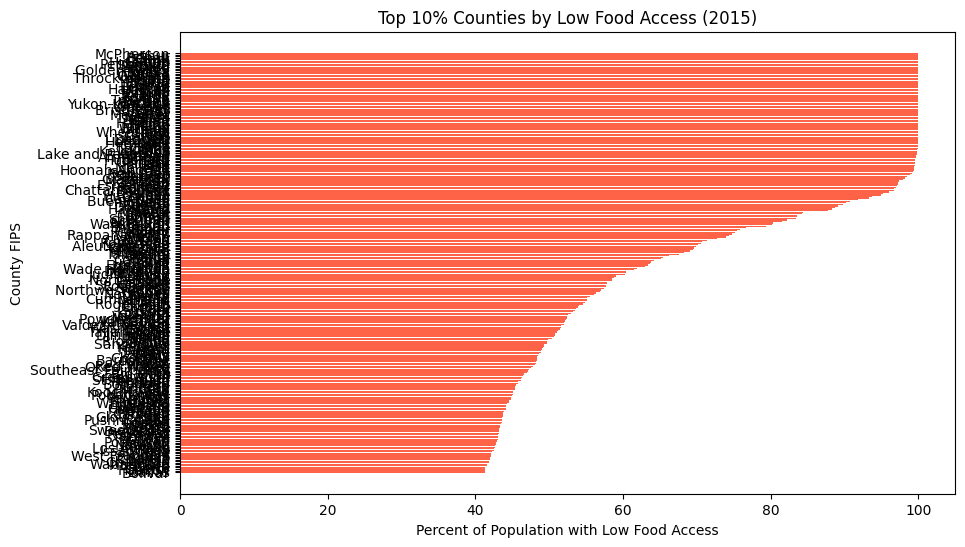

In [46]:
import matplotlib.pyplot as plt


top_counties = top_counties.sort_values('PCT_LACCESS_POP15', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(
    top_counties['County'],
    top_counties['PCT_LACCESS_POP15'],
    color='tomato'
)
plt.gca().invert_yaxis()
plt.xlabel('Percent of Population with Low Food Access')
plt.ylabel('County FIPS')
plt.title('Top 10% Counties by Low Food Access (2015)')
plt.show()


In [49]:
top_counties = top_counties.sort_values(['State', 'PCT_LACCESS_POP15'], ascending=[True, False])


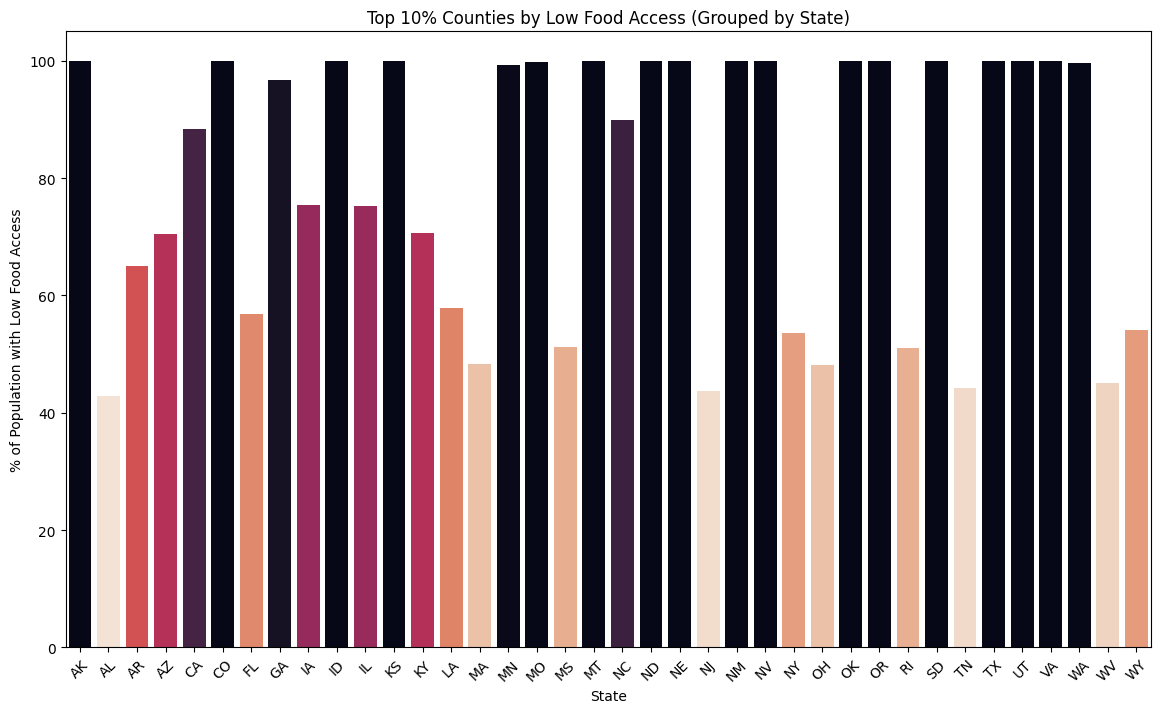

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

sns.barplot(
    data=top_counties,
    x='State',
    y='PCT_LACCESS_POP15',
    hue='PCT_LACCESS_POP15',
    dodge=False,  
    palette='rocket_r'
)

plt.ylabel('average percent low-access population across counties')
plt.title('Top 10% Counties by Low Food Access (Grouped by State)')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False) 
plt.show()


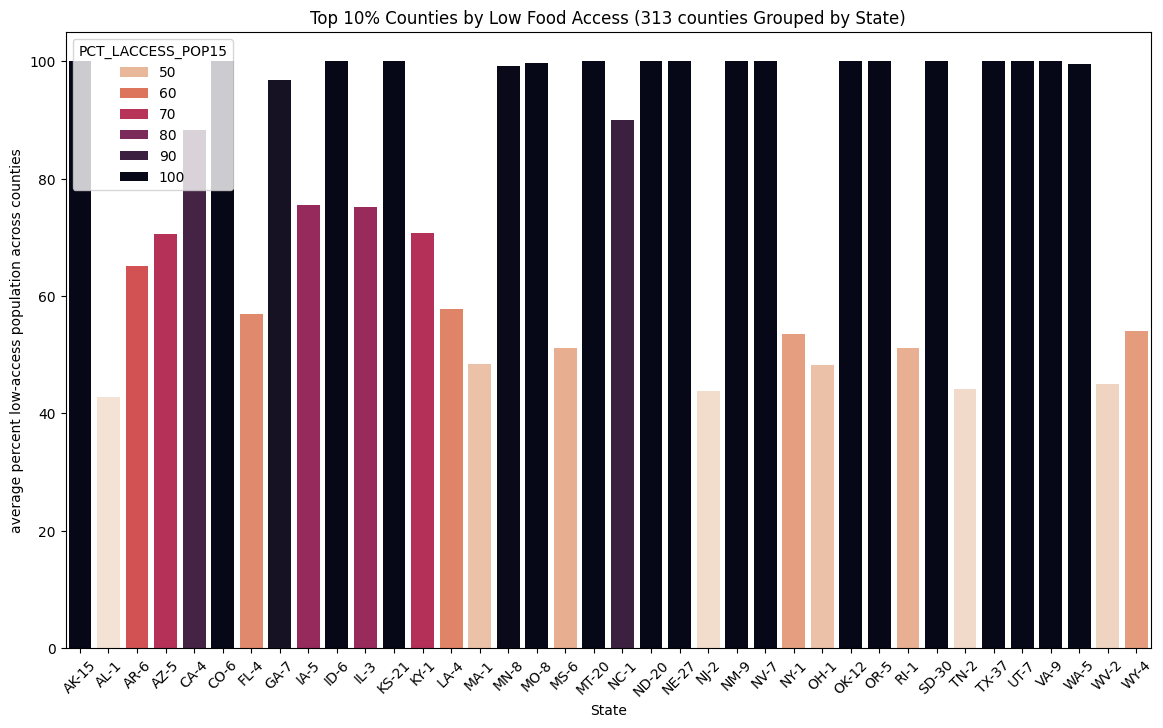

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


state_counts = top_counties.groupby('State').size()


x_labels = [f"{state}-{state_counts[state]}" for state in state_counts.index]


top_counties_sorted = top_counties.sort_values(['State', 'PCT_LACCESS_POP15'], ascending=[True, False])

plt.figure(figsize=(14, 8))

sns.barplot(
    data=top_counties_sorted,
    x='State',
    y='PCT_LACCESS_POP15',
    hue = "PCT_LACCESS_POP15",
    dodge=False,
    palette='rocket_r'
)

plt.ylabel('average percent low-access population across counties')
plt.title('Top 10% Counties by Low Food Access (313 counties Grouped by State)')


plt.xticks(ticks=range(len(state_counts)), labels=x_labels, rotation=45)

plt.show()


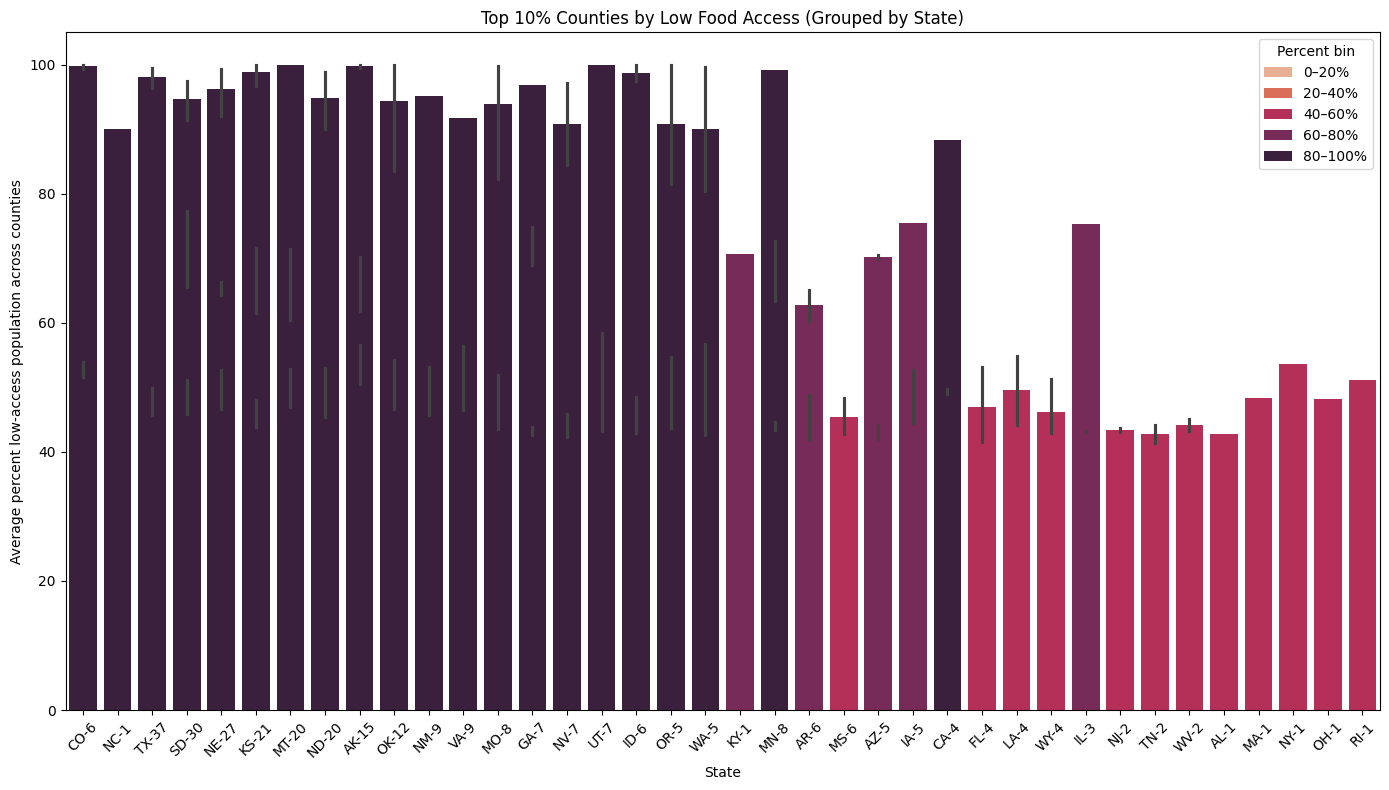

In [204]:


df = top_counties.copy()


df['pct_bin'] = pd.cut(
    df['PCT_LACCESS_POP15'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0–20%', '20–40%', '40–60%', '60–80%', '80–100%']
)


state_counts = (
    df.groupby('State')
      .size()
      .rename('n_counties')
      .reset_index()
)


state_pct = (
    df.groupby('State')['PCT_LACCESS_POP15']
      .mean()
      .rename('avg_pct')
      .reset_index()
)

state_summary = (
    state_counts
    .merge(state_pct, on='State')
)

state_summary['pct_bin'] = pd.cut(
    state_summary['avg_pct'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0–20%', '20–40%', '40–60%', '60–80%', '80–100%']
)


state_summary = state_summary.sort_values(
    ['pct_bin', 'n_counties'],
    ascending=[False, False]
)


state_order = state_summary['State'].tolist()
x_labels = [
    f"{row.State}-{row.n_counties}"
    for _, row in state_summary.iterrows()
]


plt.figure(figsize=(14, 8))

sns.barplot(
    data=df,
    x='State',
    y='PCT_LACCESS_POP15',
    order=state_order,
    hue='pct_bin',          
    dodge=False,
    palette='rocket_r'
)

plt.ylabel('Average percent low-access population across counties')
plt.title('Top 10% Counties by Low Food Access (Grouped by State)')

plt.xticks(
    ticks=range(len(state_order)),
    labels=x_labels,
    rotation=45
)

plt.legend(title='Percent bin')
plt.tight_layout()
plt.show()


SO FAR, WE HAVE DF500 WITH COUNTYFIPS, WE HAVE FOOD_ATLAS AND FOOD ATLAS MERGED WITH COUNTY SHAPE FILES AS GDF_COUNTY

Based off of the question at hand, we have chosen health indicators that are nutrition dependent, as well as access indicators to target different subpopulations.

Health indicators = PHLTH_CrudePrev, STROKE_CrudePrev, OBESITY_CrudePrev, HIGHCHOL_CrudePrev, DIABETES_CrudePrev, CHOLSCREEN_CrudePrev, CHD_CrudePrev, BPMED_CrudePrev, BPHIGH_CrudePrev (all number vars) 



**Here we have also read in the .shp files and loaded them into geopandas**

**insight into how we chose the health variables:**

In [73]:
og_health_vars = [
    'PHLTH_CrudePrev','STROKE_CrudePrev','OBESITY_CrudePrev','HIGHCHOL_CrudePrev',
    'DIABETES_CrudePrev','CHOLSCREEN_CrudePrev','CHD_CrudePrev','BPMED_CrudePrev','BPHIGH_CrudePrev']



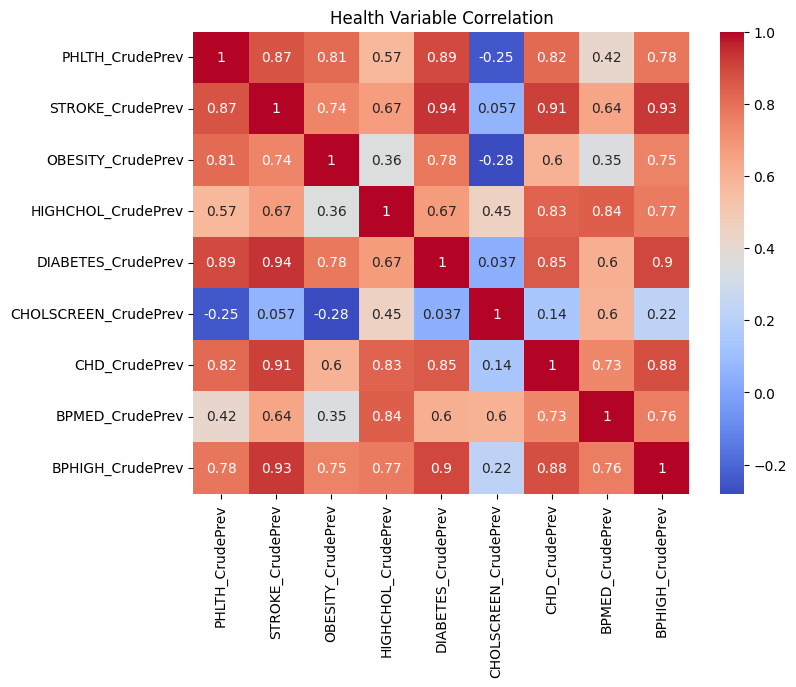

In [197]:
plt.figure(figsize=(8,6))
sns.heatmap(df500[og_health_vars].corr(), annot=True, cmap='coolwarm')
plt.title("Health Variable Correlation")
plt.show()

Thinking of removing BPMED and CHOLSCREEN because those are preventative and addressing methods, not statistics of measure. I am going to use r<|0.85| as a high correlation threshold. Here, we see stroke and diabetes have a strong correlation, stroke and high bp have a high correlation, stroke and chronic heart disease have a high correlation, high plth and diabetes correlation, high plth and stroke correlation, high diabetes and bp correlation, high diabetes and chd correlation, high chd and bp correlation, high chd and diabetes correlation, high chd and stroke correlation. We can see clusters of correlated variables, where stroke, chd, and high bp are correlated, diabetes, obesity, and high bp are correlated, phlth, diabetes, and stroke are highly correlated

Looks here like we can definitely drop the cholscreen and bpmed (as they can also be driven by healthcare access and insurance coverage) from health variables, but we want to track all population subgroups so we won't drop those subgroups.

In [94]:
cols_to_drop = [
    'STROKE_CrudePrev',
    'CHOLSCREEN_CrudePrev',
    'CHD_CrudePrev',
    'BPMED_CrudePrev'
]



We can also drop PHLTH and HIGHCOL, but we will choose not to because high colesterol is an important indicator of nutrition, and physical health is an overal indicator of health and nutrition. 

In [75]:
health_vars = [
    'PHLTH_CrudePrev', 
    'OBESITY_CrudePrev',
    'HIGHCHOL_CrudePrev', 
    'DIABETES_CrudePrev', 
    'BPHIGH_CrudePrev'
]

In [76]:

df500[health_vars] = df500[health_vars].apply(pd.to_numeric, errors='coerce')


df500['health_index'] = df500[health_vars].mean(axis=1)


df500['health_index_pct'] = df500['health_index'].rank(pct=True)

In [77]:
tracts = gpd.read_file("500Cities_Tracts/500Cities_Tracts_Clip.shp")
tracts.head()

,place2010,tract2010,ST,PlaceName,plctract10,PlcTrPop10,geometry
0,0107000,01073000100,01,Birmingham,0107000-01073000100,3042,"POLYGON ((-9653001.056 3974630.899, -9652982.0..."
1,0107000,01073000300,01,Birmingham,0107000-01073000300,2735,"POLYGON ((-9657462.853 3968794.996, -9657470.2..."
2,0107000,01073000400,01,Birmingham,0107000-01073000400,3338,"POLYGON ((-9657275.613 3972217.16, -9657275.39..."
3,0107000,01073000500,01,Birmingham,0107000-01073000500,2864,"POLYGON ((-9660666.406 3968887.964, -9660631.7..."
4,0107000,01073000700,01,Birmingham,0107000-01073000700,2577,"POLYGON ((-9661391.097 3968591.429, -9661398.2..."


In [78]:
# Merge with county food access data
health_combined = tracts.merge(
    df500, 
    left_on='tract2010',
    right_on='TractFIPS',  
    how='left'
)


In [205]:
health_combined.describe()

,PlcTrPop10,index,Population2010,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,CASTHMA_CrudePrev,...,OBESITY_CrudePrev,PAPTEST_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev,health_index,health_index_pct,PCT_LACCESS_POP15,access_pct
count,29807.000000,28196.000000,28196.000000,28194.000000,28196.000000,28196.000000,28196.000000,28196.000000,28196.000000,28196.000000,...,28196.000000,25841.000000,28196.000000,28196.000000,28196.000000,28129.000000,28196.000000,28196.000000,28158.000000,28158.000000
mean,3498.240044,13504.274046,3774.134239,16.958062,21.349149,18.082033,30.547659,70.654196,5.646194,9.709789,...,30.340651,83.055331,12.824312,36.626248,3.188991,15.954862,23.162451,0.495673,16.094151,0.500018
std,2120.457821,7927.881095,1976.477946,8.850163,5.998211,4.008197,8.222236,7.935372,1.816757,1.702731,...,8.145754,3.123423,3.992721,5.915740,1.441931,8.735417,5.220764,0.288206,9.619685,0.288620
min,0.000000,0.000000,50.000000,2.400000,2.400000,2.800000,5.300000,9.600000,0.700000,5.600000,...,9.600000,63.400000,3.400000,16.100000,0.300000,2.800000,5.420000,0.000037,0.000126,0.005007
25%,2134.000000,6581.750000,2433.000000,10.300000,17.300000,15.500000,25.200000,66.600000,4.500000,8.500000,...,24.400000,81.200000,9.800000,32.300000,2.300000,9.100000,19.720000,0.245755,7.194721,0.241033
50%,3425.000000,13456.500000,3604.000000,14.900000,20.900000,17.800000,29.300000,71.600000,5.400000,9.400000,...,29.400000,83.400000,12.200000,36.000000,2.900000,13.900000,22.520000,0.493513,16.454869,0.500799
75%,4768.000000,20444.250000,4901.000000,21.600000,25.000000,20.300000,34.700000,75.800000,6.600000,10.700000,...,35.500000,85.300000,15.300000,40.500000,3.700000,21.100000,26.080000,0.744579,23.593325,0.749769
max,28960.000000,27209.000000,28960.000000,57.800000,58.400000,44.100000,70.300000,92.800000,22.900000,17.800000,...,58.600000,90.300000,33.600000,58.700000,19.500000,57.000000,47.960000,1.000000,41.156664,0.999130


In [79]:
health_combined

,place2010,tract2010,ST,PlaceName_x,plctract10,PlcTrPop10,geometry,index,StateAbbr,PlaceName_y,...,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,county_fips,health_index,health_index_pct
0,0107000,01073000100,01,Birmingham,0107000-01073000100,3042,"POLYGON ((-9653001.056 3974630.899, -9652982.0...",0.0,AL,Birmingham,...,45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",01073,33.46,0.952922
1,0107000,01073000300,01,Birmingham,0107000-01073000300,2735,"POLYGON ((-9657462.853 3968794.996, -9657470.2...",1.0,AL,Birmingham,...,44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",01073,34.96,0.971573
2,0107000,01073000400,01,Birmingham,0107000-01073000400,3338,"POLYGON ((-9657275.613 3972217.16, -9657275.39...",2.0,AL,Birmingham,...,45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",01073,33.64,0.955605
3,0107000,01073000500,01,Birmingham,0107000-01073000500,2864,"POLYGON ((-9660666.406 3968887.964, -9660631.7...",3.0,AL,Birmingham,...,46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",01073,36.92,0.988221
4,0107000,01073000700,01,Birmingham,0107000-01073000700,2577,"POLYGON ((-9661391.097 3968591.429, -9661398.2...",4.0,AL,Birmingham,...,48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)",01073,39.74,0.998089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,15003,15003009501,15,Honolulu County,15003009501,4893,"POLYGON ((-17595986.709 2450686.821, -17595988...",9785.0,HI,Honolulu,...,48.1,"(46.3, 49.5)",0.9,"( 0.8, 1.0)",8.6,"( 5.3, 13.4)","(21.48847996930, -158.068428491)",15003,14.42,0.033333
29803,15003,15003006804,15,Honolulu County,15003006804,2835,"POLYGON ((-17577599.401 2435352.333, -17577543...",9703.0,HI,Honolulu,...,49.5,"(48.0, 50.8)",1.2,"( 1.1, 1.3)",8.5,"( 5.7, 12.1)","(21.36044454640, -157.911629164)",15003,16.38,0.070636
29804,15003,15003002701,15,Honolulu County,15003002701,5093,"POLYGON ((-17567761.096 2428519.705, -17567760...",9648.0,HI,Honolulu,...,45.7,"(43.7, 47.4)",1.2,"( 1.2, 1.3)",7.3,"( 6.0, 9.0)","(21.29785331720, -157.815958289)",15003,13.12,0.016924
29805,15003,15003003900,15,Honolulu County,15003003900,655,"POLYGON ((-17572613.958 2428743.983, -17572601...",9669.0,HI,Honolulu,...,46.3,"(44.8, 47.7)",4.4,"( 3.9, 5.0)",11.0,"( 7.4, 15.7)","(21.30266401140, -157.861860063)",15003,27.32,0.802885


In [80]:
# Ensure food_atlas has county_fips and percent low access population

health_combined = health_combined.merge(
    food_atlas[['county_fips', 'PCT_LACCESS_POP15']], 
    on='county_fips',
    how='left'
)


In [82]:
health_combined['access_pct'] = health_combined['PCT_LACCESS_POP15'].rank(pct=True)

# Thresholds for top 10%
health_threshold = health_combined['health_index_pct'].quantile(0.90)
access_threshold = health_combined['access_pct'].quantile(0.90)

In [83]:
health_combined

,place2010,tract2010,ST,PlaceName_x,plctract10,PlcTrPop10,geometry,index,StateAbbr,PlaceName_y,...,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,county_fips,health_index,health_index_pct,PCT_LACCESS_POP15,access_pct
0,0107000,01073000100,01,Birmingham,0107000-01073000100,3042,"POLYGON ((-9653001.056 3974630.899, -9652982.0...",0.0,AL,Birmingham,...,5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)",01073,33.46,0.952922,31.232876,0.949126
1,0107000,01073000300,01,Birmingham,0107000-01073000300,2735,"POLYGON ((-9657462.853 3968794.996, -9657470.2...",1.0,AL,Birmingham,...,6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)",01073,34.96,0.971573,31.232876,0.949126
2,0107000,01073000400,01,Birmingham,0107000-01073000400,3338,"POLYGON ((-9657275.613 3972217.16, -9657275.39...",2.0,AL,Birmingham,...,5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)",01073,33.64,0.955605,31.232876,0.949126
3,0107000,01073000500,01,Birmingham,0107000-01073000500,2864,"POLYGON ((-9660666.406 3968887.964, -9660631.7...",3.0,AL,Birmingham,...,7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)",01073,36.92,0.988221,31.232876,0.949126
4,0107000,01073000700,01,Birmingham,0107000-01073000700,2577,"POLYGON ((-9661391.097 3968591.429, -9661398.2...",4.0,AL,Birmingham,...,9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)",01073,39.74,0.998089,31.232876,0.949126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,15003,15003009501,15,Honolulu County,15003009501,4893,"POLYGON ((-17595986.709 2450686.821, -17595988...",9785.0,HI,Honolulu,...,0.9,"( 0.8, 1.0)",8.6,"( 5.3, 13.4)","(21.48847996930, -158.068428491)",15003,14.42,0.033333,23.128783,0.731462
29803,15003,15003006804,15,Honolulu County,15003006804,2835,"POLYGON ((-17577599.401 2435352.333, -17577543...",9703.0,HI,Honolulu,...,1.2,"( 1.1, 1.3)",8.5,"( 5.7, 12.1)","(21.36044454640, -157.911629164)",15003,16.38,0.070636,23.128783,0.731462
29804,15003,15003002701,15,Honolulu County,15003002701,5093,"POLYGON ((-17567761.096 2428519.705, -17567760...",9648.0,HI,Honolulu,...,1.2,"( 1.2, 1.3)",7.3,"( 6.0, 9.0)","(21.29785331720, -157.815958289)",15003,13.12,0.016924,23.128783,0.731462
29805,15003,15003003900,15,Honolulu County,15003003900,655,"POLYGON ((-17572613.958 2428743.983, -17572601...",9669.0,HI,Honolulu,...,4.4,"( 3.9, 5.0)",11.0,"( 7.4, 15.7)","(21.30266401140, -157.861860063)",15003,27.32,0.802885,23.128783,0.731462


In [84]:
def categorize(row):
    if row['health_index_pct'] >= health_threshold and row['access_pct'] >= access_threshold:
        return 'Both'
    elif row['health_index_pct'] >= health_threshold:
        return 'Health Only'
    elif row['access_pct'] >= access_threshold:
        return 'Access Only'
    else:
        return 'None'

health_combined['priority_category'] = health_combined.apply(categorize, axis=1)


In [85]:
county_summary = health_combined.groupby('county_fips').agg({
    'health_index': 'mean',
    'PCT_LACCESS_POP15': 'mean',
    'priority_category': lambda x: x.value_counts().idxmax()  
}).reset_index()


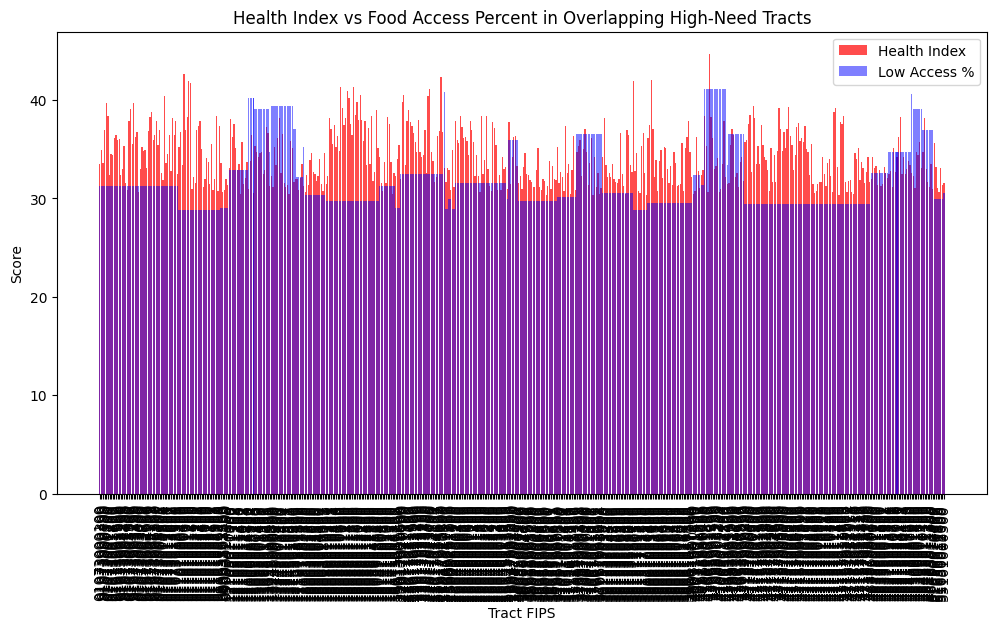

In [88]:

both_tracts = health_combined[health_combined['priority_category'] == 'Both']

plt.figure(figsize=(12,6))
plt.bar(
    both_tracts['tract2010'], 
    both_tracts['health_index'], 
    color='red', 
    alpha=0.7,
    label='Health Index'
)
plt.bar(
    both_tracts['tract2010'], 
    both_tracts['PCT_LACCESS_POP15'], 
    color='blue', 
    alpha=0.5,
    label='Low Access %'
)

plt.ylabel('Score')
plt.xlabel('Tract FIPS')
plt.title('Health Index vs Food Access Percent in Overlapping High-Need Tracts')
plt.legend()
plt.xticks(rotation=90)
plt.show()


In [93]:

overlap_tracts_df = health_combined[health_combined['priority_category'] == 'Both'].copy()





In [92]:
overlap_tracts_df['PlaceName_x'].unique()

array(['Birmingham', 'Montgomery', 'Hartford', 'New Britain', 'Lakeland',
       'Melbourne', 'Palm Bay', 'Albany', 'Athens', 'Augusta',
       'Warner Robins', 'Joliet', 'Waukegan', 'Fort Wayne', 'Gary',
       'Hammond', 'South Bend', 'Waterloo', 'Shreveport', 'Brockton',
       'Fall River', 'Lawrence', 'Lynn', 'New Bedford', 'Flint',
       'Southfield', 'Gulfport', 'Rochester', 'Fayetteville',
       'Wilmington', 'Winston-Salem', 'Akron', 'Canton', 'Cincinnati',
       'Lawton', 'Tulsa', 'Chattanooga', 'Clarksville', 'Knoxville',
       'Memphis', 'Corpus Christi', 'Edinburg', 'McAllen', 'Mission',
       'Pharr', 'San Angelo', 'Waco', 'Wichita Falls', 'Hampton',
       'Racine'], dtype=object)

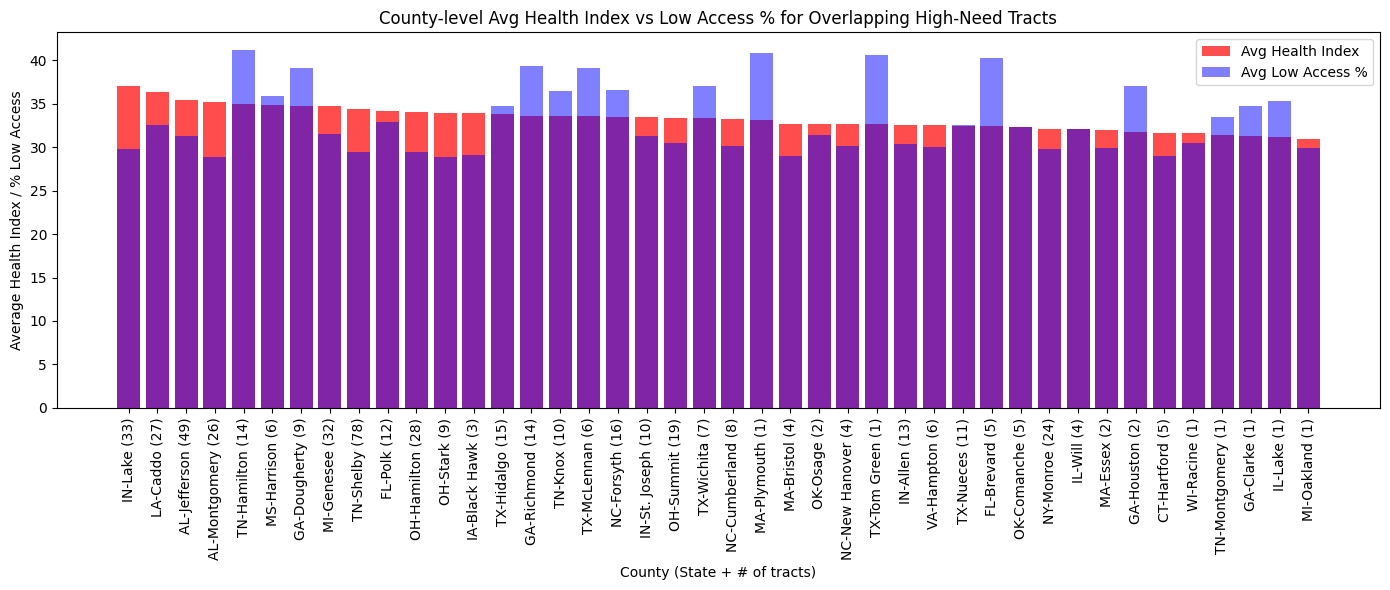

In [98]:
import matplotlib.pyplot as plt
import pandas as pd


both_tracts = health_combined[health_combined['priority_category'] == 'Both'].copy()


both_tracts = both_tracts.merge(
    food_atlas[['county_fips', 'County']],
    on='county_fips',
    how='left'
)

=
county_summary = both_tracts.groupby(['county_fips', 'StateAbbr', 'County']).agg(
    avg_health_index=('health_index', 'mean'),
    avg_low_access_pct=('PCT_LACCESS_POP15', 'mean'),
    tract_count=('tract2010', 'count')
).reset_index()

county_summary['x_label'] = county_summary.apply(
    lambda row: f"{row['StateAbbr']}-{row['County']} ({row['tract_count']})", axis=1
)

county_summary = county_summary.sort_values('avg_health_index', ascending=False)

plt.figure(figsize=(14,6))
plt.bar(
    county_summary['x_label'], 
    county_summary['avg_health_index'], 
    color='red', 
    alpha=0.7,
    label='Avg Health Index'
)
plt.bar(
    county_summary['x_label'], 
    county_summary['avg_low_access_pct'], 
    color='blue', 
    alpha=0.5,
    label='Avg Low Access %'
)

plt.ylabel('Average Health Index / % Low Access')
plt.xlabel('County (State + # of tracts)')
plt.title('County-level Avg Health Index vs Low Access % for Overlapping High-Need Tracts')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [100]:
subgroup_counts = [
    'LACCESS_POP15',   
    'LACCESS_SENIORS15',
    'LACCESS_CHILD15',
    'LACCESS_LOWI15',
    'LACCESS_HHNV15',
    'LACCESS_WHITE15',
    'LACCESS_BLACK15',
    'LACCESS_HISP15',
    'LACCESS_NHASIAN15',
    'LACCESS_NHNA15',
    'LACCESS_NHPI15',
    'LACCESS_MULTIR15'
]

subgroup_pct = [f'PCT_{c}' for c in subgroup_counts]  


In [102]:
# merge food access data into both_tracts
both_tracts = both_tracts.merge(
    food_atlas[['county_fips'] + [
        'LACCESS_POP15','LACCESS_SENIORS15','LACCESS_CHILD15','LACCESS_LOWI15',
        'LACCESS_HHNV15','LACCESS_WHITE15','LACCESS_BLACK15','LACCESS_HISP15',
        'LACCESS_NHASIAN15','LACCESS_NHNA15','LACCESS_NHPI15','LACCESS_MULTIR15'
    ]],
    on='county_fips',
    how='left'
)


In [105]:
both_tracts

,place2010,tract2010,ST,PlaceName_x,plctract10,PlcTrPop10,geometry,index,StateAbbr,PlaceName_y,...,LACCESS_CHILD15,LACCESS_LOWI15,LACCESS_HHNV15,LACCESS_WHITE15,LACCESS_BLACK15,LACCESS_HISP15,LACCESS_NHASIAN15,LACCESS_NHNA15,LACCESS_NHPI15,LACCESS_MULTIR15
0,0107000,01073000100,01,Birmingham,0107000-01073000100,3042,"POLYGON ((-9653001.056 3974630.899, -9652982.0...",0.0,AL,Birmingham,...,49882.802400,80804.251855,7229.284660,94905.921002,102009.896548,7097.673679,1808.048713,476.945542,80.060491,6376.995723
1,0107000,01073000300,01,Birmingham,0107000-01073000300,2735,"POLYGON ((-9657462.853 3968794.996, -9657470.2...",1.0,AL,Birmingham,...,49882.802400,80804.251855,7229.284660,94905.921002,102009.896548,7097.673679,1808.048713,476.945542,80.060491,6376.995723
2,0107000,01073000400,01,Birmingham,0107000-01073000400,3338,"POLYGON ((-9657275.613 3972217.16, -9657275.39...",2.0,AL,Birmingham,...,49882.802400,80804.251855,7229.284660,94905.921002,102009.896548,7097.673679,1808.048713,476.945542,80.060491,6376.995723
3,0107000,01073000500,01,Birmingham,0107000-01073000500,2864,"POLYGON ((-9660666.406 3968887.964, -9660631.7...",3.0,AL,Birmingham,...,49882.802400,80804.251855,7229.284660,94905.921002,102009.896548,7097.673679,1808.048713,476.945542,80.060491,6376.995723
4,0107000,01073000700,01,Birmingham,0107000-01073000700,2577,"POLYGON ((-9661391.097 3968591.429, -9661398.2...",4.0,AL,Birmingham,...,49882.802400,80804.251855,7229.284660,94905.921002,102009.896548,7097.673679,1808.048713,476.945542,80.060491,6376.995723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,5135000,51650011800,51,Hampton,5135000-51650011800,4880,"POLYGON ((-8499220.299 4442305.148, -8499220.7...",25881.0,VA,Hampton,...,9547.697075,14175.168917,1411.036944,17099.654004,21019.706827,1727.142066,1002.045925,167.410451,39.785810,1887.148219
521,5135000,51650011900,51,Hampton,5135000-51650011900,3178,"POLYGON ((-8502205.332 4440199.279, -8502343.7...",25882.0,VA,Hampton,...,9547.697075,14175.168917,1411.036944,17099.654004,21019.706827,1727.142066,1002.045925,167.410451,39.785810,1887.148219
522,5135000,51650012000,51,Hampton,5135000-51650012000,3217,"POLYGON ((-8502205.332 4440199.279, -8502207.6...",25883.0,VA,Hampton,...,9547.697075,14175.168917,1411.036944,17099.654004,21019.706827,1727.142066,1002.045925,167.410451,39.785810,1887.148219
523,5566000,55101000500,55,Racine,5566000-55101000500,5269,"POLYGON ((-9773693.428 5271797.302, -9773691.4...",27159.0,WI,Racine,...,14768.832375,16268.448863,1771.918516,47648.644978,6471.666452,6778.620312,560.612879,259.084788,15.388088,4673.270042


,Both_Tracts,All_Low_Access,Percent_Captured
LACCESS_BLACK15,2.596917e+07,7.089695e+06,366.294548
LACCESS_LOWI15,3.060072e+07,1.821946e+07,167.956302
LACCESS_CHILD15,2.211574e+07,1.481707e+07,149.258474
LACCESS_POP15,8.582245e+07,6.025492e+07,142.432256
LACCESS_SENIORS15,1.042930e+07,8.029978e+06,129.879547
LACCESS_HHNV15,2.599448e+06,2.115564e+06,122.872613
LACCESS_HISP15,8.698197e+06,7.266679e+06,119.699757
LACCESS_WHITE15,5.403544e+07,4.614145e+07,117.108229
LACCESS_MULTIR15,3.838081e+06,4.032457e+06,95.179719
LACCESS_NHASIAN15,1.674180e+06,2.171380e+06,77.102087


In [145]:
len(both_tracts["county_fips"].unique())

42

In [106]:
total_pop_both_tracts = both_tracts['Population2010'].sum()
total_pop_both_tracts

1515998.0

In [115]:
type(total_low_access)


numpy.float64

In [114]:
total_low_access = food['LACCESS_POP15'].sum()
total_low_access

60254922.83399637

In [116]:
coverage_pct = (total_pop_both_tracts / total_low_access) * 100
coverage_pct


2.5159736809830586

In [117]:
remaining_low_access = total_low_access - total_pop_both_tracts


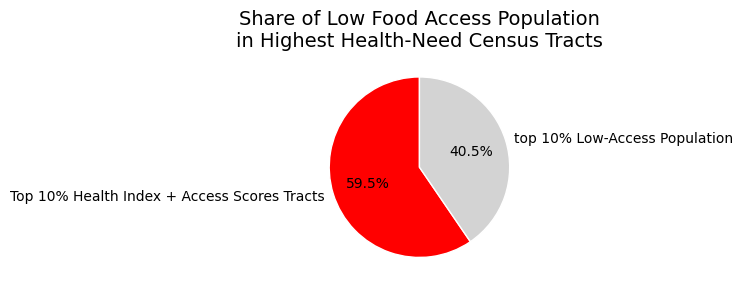

In [219]:
import matplotlib.pyplot as plt

labels = [
    'Top 10% Health Index + Access Scores Tracts',
    'Only Top 10% Low-Access Population'
]

sizes = [
    total_pop_both_tracts,
    top_10_sum-total_pop_both_tracts
]

colors = ['red', 'lightgrey']

plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%' if p > 1 else '',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)

plt.title(
    'Share of Low Food Access Population\nin Highest Health-Need Census Tracts',
    fontsize=14
)

plt.tight_layout()
plt.show()


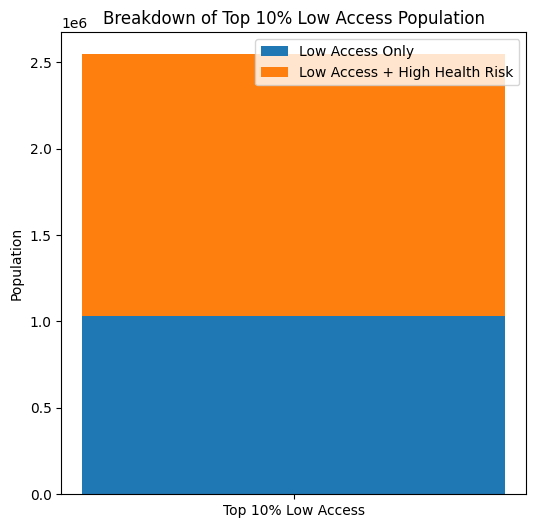

In [218]:
import matplotlib.pyplot as plt

total = 2545992
subset = 1515998
remainder = total - subset

plt.figure(figsize=(6,6))

plt.bar(["Top 10% Low Access"], [remainder], label="Low Access Only")
plt.bar(["Top 10% Low Access"], [subset], bottom=[remainder], label="Low Access + High Health Risk")

plt.ylabel("Population")
plt.title("Breakdown of Top 10% Low Access Population")
plt.legend()

plt.show()


In [149]:
food

,county_fips,index,FIPS,State,County,LACCESS_POP15,LACCESS_CHILD15,LACCESS_SENIORS15,LACCESS_LOWI15,LACCESS_HHNV15,...,PCT_LACCESS_HHNV15,PCT_LACCESS_SNAP15,PCT_LACCESS_BLACK15,PCT_LACCESS_WHITE15,PCT_LACCESS_HISP15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_MULTIR15,high_access_need
0,01001,0,1001,AL,Autauga,17496.693038,4616.971480,2180.809285,6543.676824,677.672769,...,3.351332,4.608749,7.726582,23.163613,0.863345,0.159000,0.112092,0.016159,0.884808,False
1,01003,1,1003,AL,Baldwin,30561.264430,7007.972675,5580.662790,9886.831137,1394.162766,...,1.905114,1.298900,1.942757,13.981393,0.755973,0.116833,0.099662,0.008131,0.618712,False
2,01005,2,1005,AL,Barbour,6069.523628,1031.927776,824.175262,2948.790251,425.144927,...,4.329378,4.303147,9.881360,10.302934,1.855183,0.062266,0.145539,0.029436,1.684025,False
3,01007,3,1007,AL,Bibb,969.378841,232.642670,137.688231,596.162829,224.388125,...,2.821427,0.676710,1.828933,2.358770,0.037516,0.008703,0.010967,0.000000,0.022951,False
4,01009,4,1009,AL,Blount,3724.428242,910.686113,505.914282,1650.959482,719.931444,...,3.336414,0.812727,0.167201,5.909147,0.867886,0.014705,0.050484,0.001854,0.353990,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,56037,3138,56037,WY,Sweetwater,18934.737809,4852.757500,1951.212126,4750.905615,359.608360,...,2.182752,2.141828,0.425235,38.376031,6.075311,0.261887,0.432866,0.063280,3.664775,True
3139,56039,3139,56039,WY,Teton,6212.390430,1096.186959,657.160241,1577.771012,48.474161,...,0.540222,0.670815,0.042687,26.525900,3.457192,0.251196,0.152542,0.039771,2.162273,False
3140,56041,3140,56041,WY,Uinta,4686.017653,1439.223015,437.130401,2054.179828,211.630840,...,2.759922,2.072485,0.070981,20.172127,2.536304,0.065497,0.191020,0.031187,1.658871,False
3141,56043,3141,56043,WY,Washakie,931.411647,184.506884,219.490015,309.030331,42.030853,...,1.203633,1.053980,0.023438,10.358342,0.415733,0.074614,0.058678,0.000000,0.400334,False


In [150]:
food.columns


Index(['county_fips', 'index', 'FIPS', 'State', 'County', 'LACCESS_POP15',
       'LACCESS_CHILD15', 'LACCESS_SENIORS15', 'LACCESS_LOWI15',
       'LACCESS_HHNV15', 'LACCESS_SNAP15', 'LACCESS_BLACK15',
       'LACCESS_WHITE15', 'LACCESS_HISP15', 'LACCESS_NHASIAN15',
       'LACCESS_NHNA15', 'LACCESS_NHPI15', 'LACCESS_MULTIR15',
       'PCT_LACCESS_POP15', 'PCT_LACCESS_CHILD15', 'PCT_LACCESS_SENIORS15',
       'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15',
       'PCT_LACCESS_BLACK15', 'PCT_LACCESS_WHITE15', 'PCT_LACCESS_HISP15',
       'PCT_LACCESS_NHASIAN15', 'PCT_LACCESS_NHNA15', 'PCT_LACCESS_NHPI15',
       'PCT_LACCESS_MULTIR15', 'high_access_need'],
      dtype='object')

In [161]:

both_tracts.columns

Index(['place2010', 'tract2010', 'ST', 'PlaceName_x', 'plctract10',
       'PlcTrPop10', 'geometry', 'index', 'StateAbbr', 'PlaceName_y',
       'PlaceFIPS', 'TractFIPS', 'Place_TractID', 'Population2010',
       'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI', 'ARTHRITIS_CrudePrev',
       'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev', 'BINGE_Crude95CI',
       'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI', 'BPMED_CrudePrev',
       'BPMED_Crude95CI', 'CANCER_CrudePrev', 'CANCER_Crude95CI',
       'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI', 'CHD_CrudePrev',
       'CHD_Crude95CI', 'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI',
       'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DIABETES_CrudePrev', 'DIABETES_Crude95CI', 'HIGHCHO

In [157]:
high_access_need_df = food.loc[
    food['high_access_need'] == True,
    ['County', 'State', 'county_fips']
].reset_index(drop=True)
low_access_need_df = food.loc[
    food['high_access_need'] == False,
    ['County', 'State', 'county_fips']
].reset_index(drop=True)


In [158]:
overlap_fips = set(high_access_need_df['county_fips']) & set(low_access_need_df['county_fips'])

len(overlap_fips)


0

In [174]:
both_tracts.columns

Index(['place2010', 'tract2010', 'ST', 'PlaceName_x', 'plctract10',
       'PlcTrPop10', 'geometry', 'index', 'StateAbbr', 'PlaceName_y',
       'PlaceFIPS', 'TractFIPS', 'Place_TractID', 'Population2010',
       'ACCESS2_CrudePrev', 'ACCESS2_Crude95CI', 'ARTHRITIS_CrudePrev',
       'ARTHRITIS_Crude95CI', 'BINGE_CrudePrev', 'BINGE_Crude95CI',
       'BPHIGH_CrudePrev', 'BPHIGH_Crude95CI', 'BPMED_CrudePrev',
       'BPMED_Crude95CI', 'CANCER_CrudePrev', 'CANCER_Crude95CI',
       'CASTHMA_CrudePrev', 'CASTHMA_Crude95CI', 'CHD_CrudePrev',
       'CHD_Crude95CI', 'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI',
       'CHOLSCREEN_CrudePrev', 'CHOLSCREEN_Crude95CI',
       'COLON_SCREEN_CrudePrev', 'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev',
       'COPD_Crude95CI', 'COREM_CrudePrev', 'COREM_Crude95CI',
       'COREW_CrudePrev', 'COREW_Crude95CI', 'CSMOKING_CrudePrev',
       'CSMOKING_Crude95CI', 'DENTAL_CrudePrev', 'DENTAL_Crude95CI',
       'DIABETES_CrudePrev', 'DIABETES_Crude95CI', 'HIGHCHO

In [162]:

high_access_need_df['access_need'] = 'high'
low_access_need_df['access_need'] = 'low'


county_access_df = pd.concat(
    [high_access_need_df, low_access_need_df],
    ignore_index=True
)


county_access_df['color'] = county_access_df['access_need'].map({
    'high': 'red',
    'low': 'lightgrey'
})


In [163]:
both_tract_counties = set(both_tracts['county_fips'])

county_access_df['color'] = county_access_df.apply(
    lambda row: 'blue' if row['county_fips'] in both_tract_counties else row['color'],
    axis=1
)


In [164]:
county_access_df['color'].value_counts()


color
lightgrey    2788
red           313
blue           42
Name: count, dtype: int64

In [166]:
county_access_df['county_fips'] = county_access_df['county_fips'].astype(str)


gdf_map = county_shp.merge(
    county_access_df,
    on='county_fips',
    how='left'
)


In [171]:
gdf_map['color'] = gdf_map['color'].fillna('lightgrey')


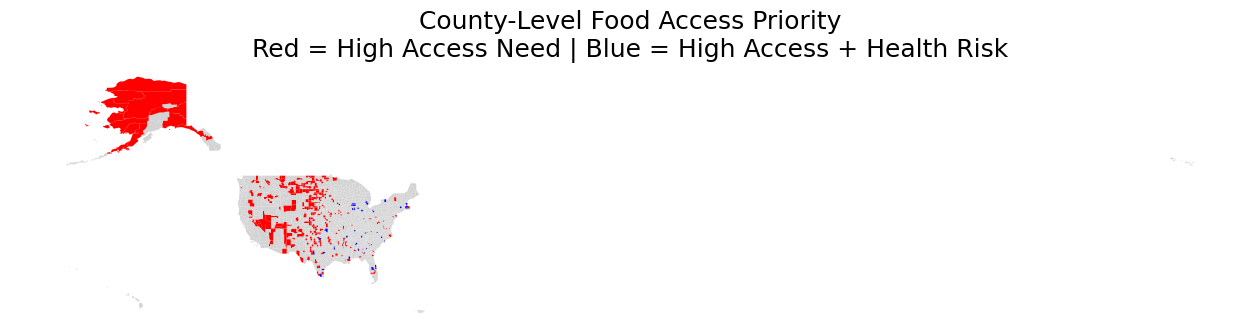

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

gdf_map.plot(
    color=gdf_map['color'],
    linewidth=0.15,
    ax=ax
)

ax.set_title(
    'County-Level Food Access Priority\n'
    'Red = High Access Need | Blue = High Access + Health Risk',
    fontsize=18
)

ax.axis('off')
plt.show()


In [175]:
subgroup_totals = both_tracts[[
    'LACCESS_POP15',
    'LACCESS_SENIORS15',
    'LACCESS_CHILD15',
    'LACCESS_LOWI15',
    'LACCESS_WHITE15',
    'LACCESS_BLACK15',
    'LACCESS_HISP15',
    'LACCESS_NHASIAN15',
    'LACCESS_NHNA15',
    'LACCESS_NHPI15',
    'LACCESS_MULTIR15'
]].sum()


In [176]:
subgroup_df = (
    subgroup_totals
    .reset_index()
    .rename(columns={'index': 'subgroup', 0: 'population'})
)

subgroup_df


,subgroup,population
0,LACCESS_POP15,8.582245e+07
1,LACCESS_SENIORS15,1.042930e+07
2,LACCESS_CHILD15,2.211574e+07
3,LACCESS_LOWI15,3.060072e+07
4,LACCESS_WHITE15,5.403544e+07
5,LACCESS_BLACK15,2.596917e+07
6,LACCESS_HISP15,8.698197e+06
7,LACCESS_NHASIAN15,1.674180e+06
8,LACCESS_NHNA15,2.610768e+05
9,LACCESS_NHPI15,4.450254e+04


In [177]:
label_map = {
    'LACCESS_POP15': 'Total Population',
    'LACCESS_SENIORS15': 'Seniors (65+)',
    'LACCESS_CHILD15': 'Children',
    'LACCESS_LOWI15': 'Low Income',
    'LACCESS_WHITE15': 'White',
    'LACCESS_BLACK15': 'Black',
    'LACCESS_HISP15': 'Hispanic',
    'LACCESS_NHASIAN15': 'Asian',
    'LACCESS_NHNA15': 'Native American',
    'LACCESS_NHPI15': 'Pacific Islander',
    'LACCESS_MULTIR15': 'Multiracial'
}

subgroup_df['subgroup'] = subgroup_df['subgroup'].map(label_map)


In [178]:
total_pop = subgroup_df.loc[
    subgroup_df['subgroup'] == 'Total Population', 'population'
].iloc[0]

subgroup_df['share_pct'] = (
    subgroup_df['population'] / total_pop * 100
).round(1)


In [179]:
subgroup_df_plot = subgroup_df[
    subgroup_df['subgroup'] != 'Total Population'
].sort_values('population', ascending=False)


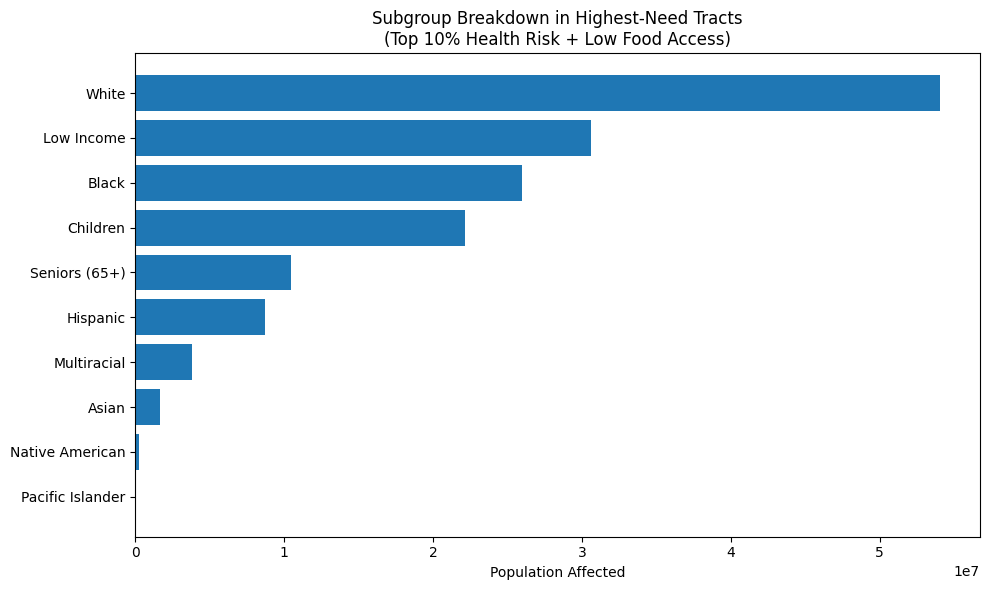

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    subgroup_df_plot['subgroup'],
    subgroup_df_plot['population']
)

plt.xlabel('Population Affected')
plt.title(
    'Subgroup Breakdown in Highest-Need Tracts\n'
    '(Top 10% Health Risk + Low Food Access)'
)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In tracts where both health risk and food access burden are highest, the affected population is white and low-income, with substantial representation of children, seniors, and communities of color. These areas are likely to show higher engagement and retention, since food access interventions directly address both medical and social risk drivers.

In [ ]:
# use percent change data to predict, then add the plausible success rate to it